# Gruppe J

<table>
  <tbody>
    <tr>
      <th>Nachname</th>
      <th>Vorname</th>
      <th>Matrikelnr.</th>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Dietrich</td>
      <td>Maximilian</td>
      <td>395320</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Harisha</td>
      <td>Adithya Sakrepatna</td>
      <td>455906</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Konrad</td>
      <td>Jimmy</td>
      <td>463221</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Lian</td>
      <td>David</td>
      <td>451051</td>
    </tr>
  </tbody>
</table>



## Modulimport

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from multiprocessing import cpu_count

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

### Datenimport

In [3]:
try:
    df_train    = pd.read_excel("data/Aufgabe_2_CAE.xlsx", sheet_name="Trainingsdaten")
    df_test     = pd.read_excel("data/Aufgabe_2_CAE.xlsx", sheet_name="Testdaten")
except:
    df_train    = pd.read_excel("Aufgabe_2_CAE.xlsx", sheet_name="Trainingsdaten")
    df_test     = pd.read_excel("Aufgabe_2_CAE.xlsx", sheet_name="Testdaten")

pd.set_option('display.expand_frame_repr', False) # keine Daten beim Print ausblenden
print('Dimensionen des Trainings-Datensatzes "CAE": %d, %d\n' % df_train.shape)
print('Dimensionen des Test-Datensatzes "CAE": %d, %d\n' % df_test.shape)
print(df_train.tail())

Dimensionen des Trainings-Datensatzes "CAE": 2901, 4

Dimensionen des Test-Datensatzes "CAE": 671, 4

      Zeit in s  Stromdichte in A/m^2  Eintrittstemperatur Zelle in °C  Zelltemperatur in °C
2896     289600                  5515                        70.227719             85.520703
2897     289700                  5515                        70.227719             85.511869
2898     289800                  5515                        70.227719             85.504101
2899     289900                  5515                        70.227719             85.497274
2900     290000                  5515                        78.007436             85.491274


### Darstellung der importierten Daten

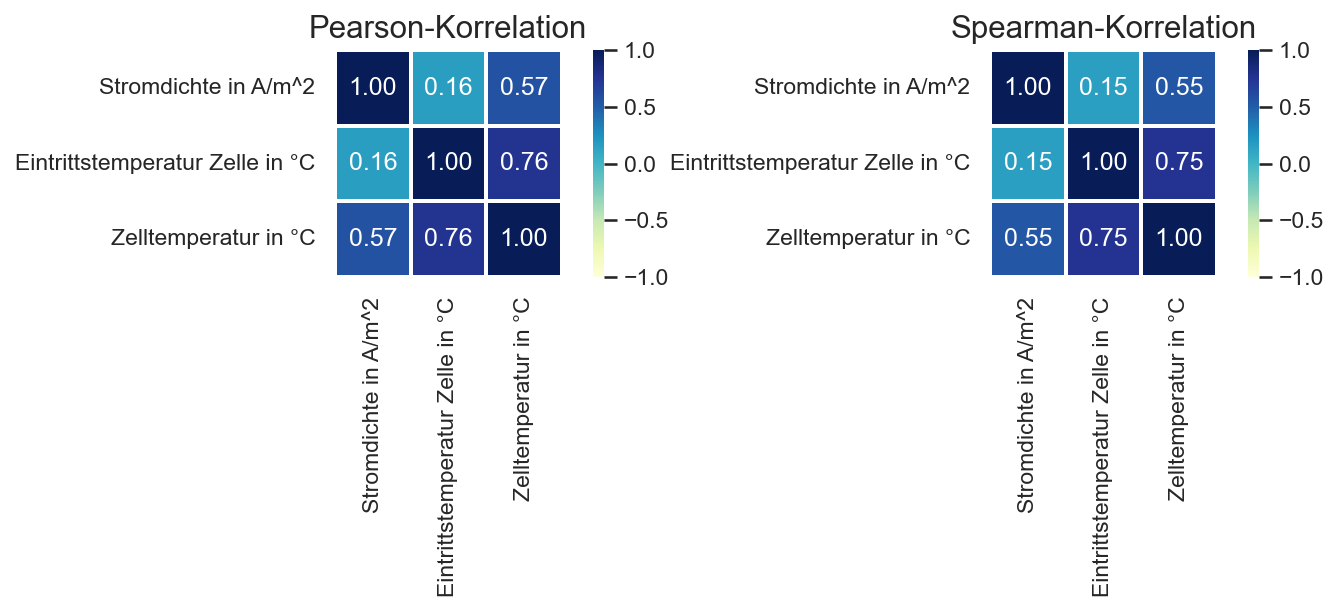

<Figure size 4500x4500 with 0 Axes>

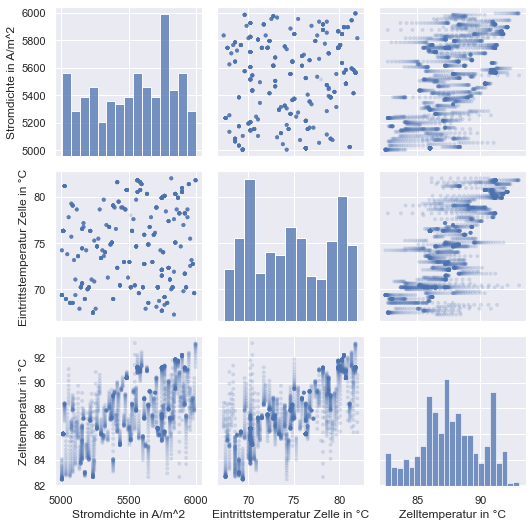

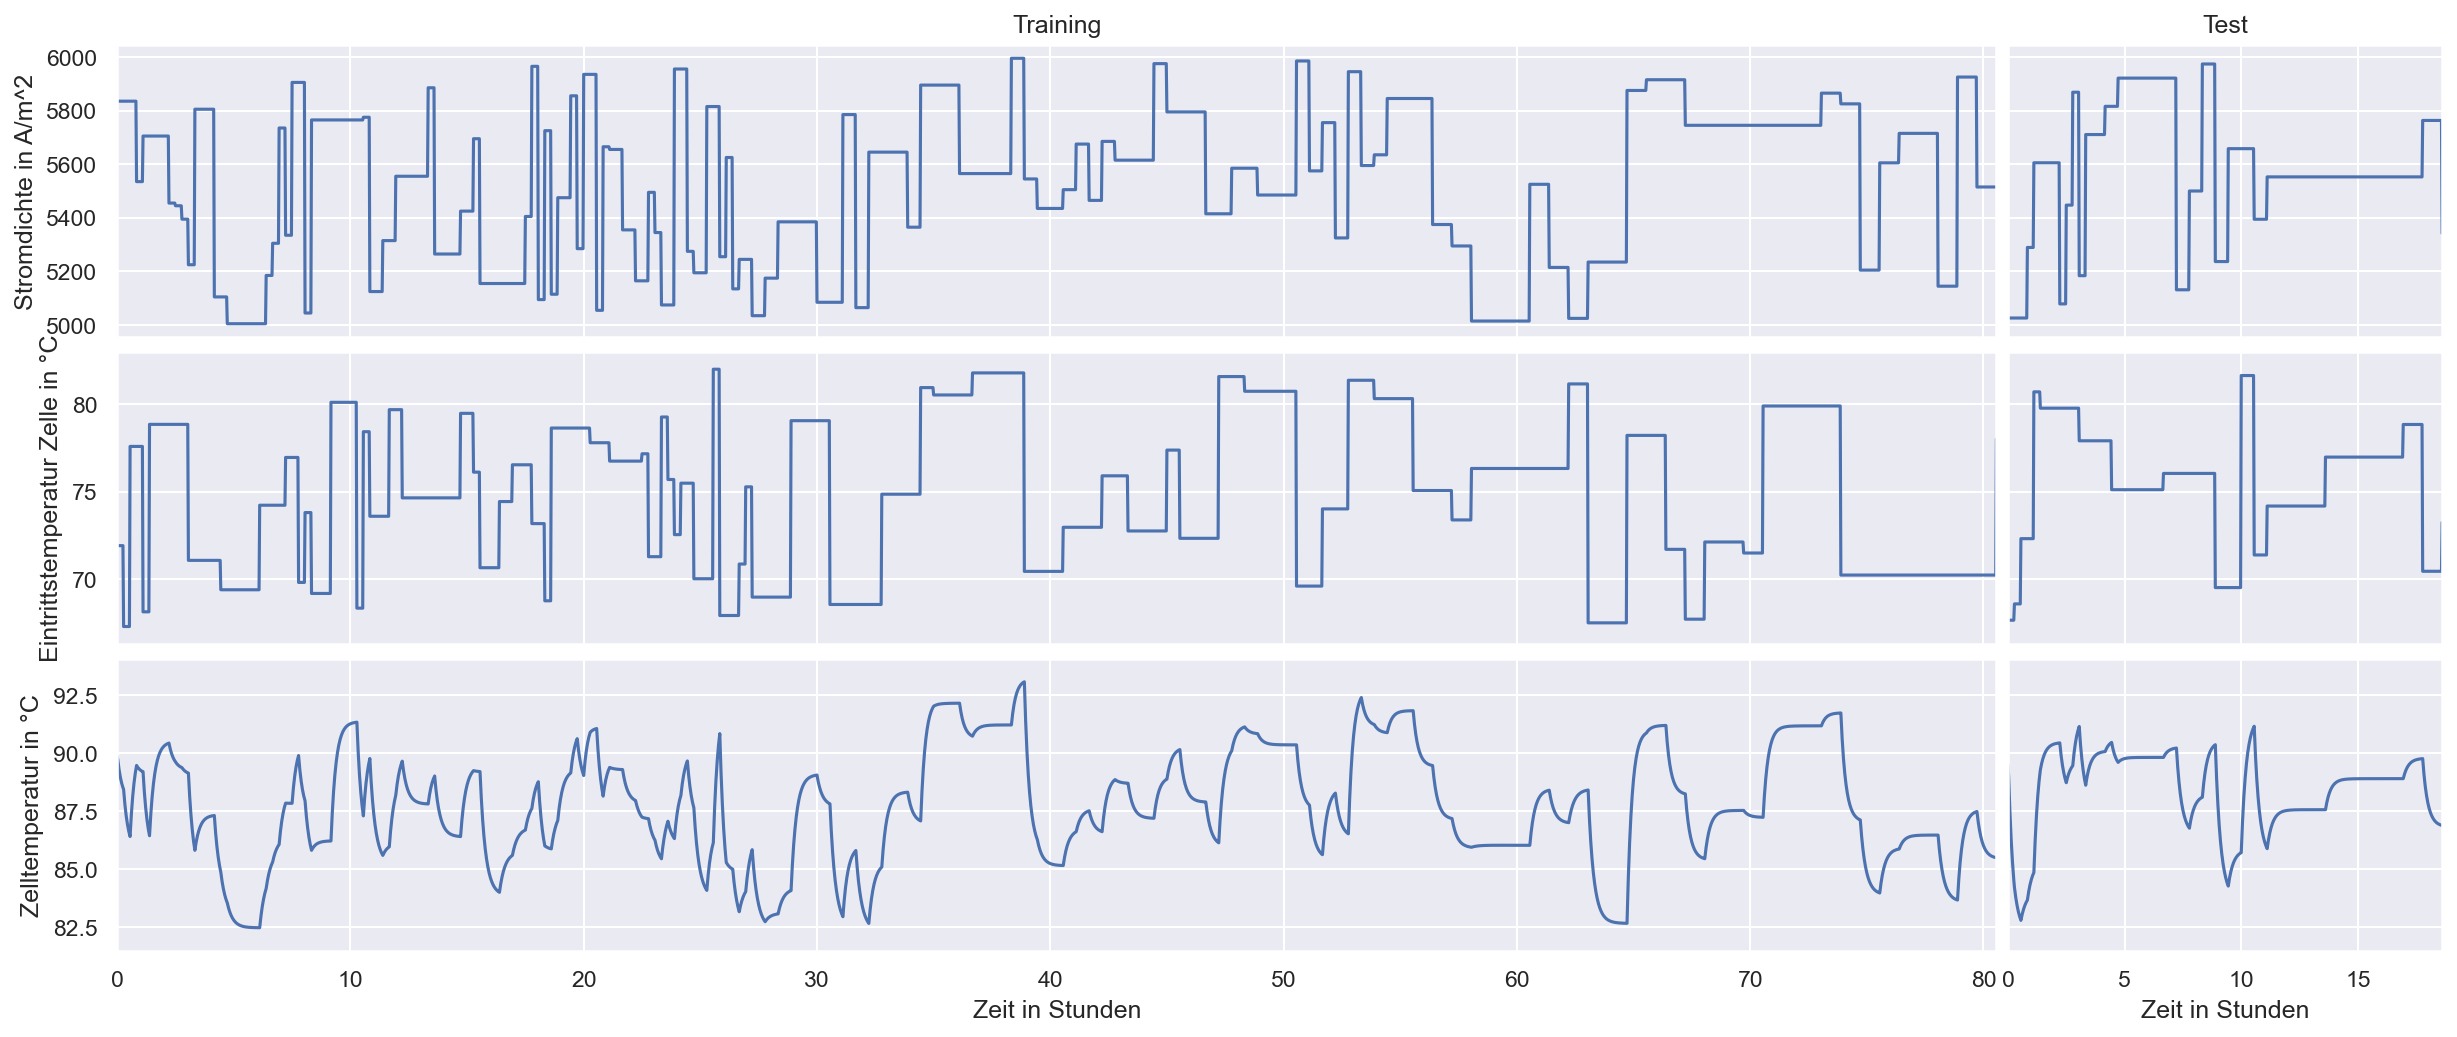

In [10]:
# Korrelationsmatrix berechnen und darstellen
r_pearson   = df_train.iloc[:,1:].corr(method='pearson')
r_spearman  = df_train.iloc[:,1:].corr(method='spearman')

fig1, ax = plt.subplots(1, 2, figsize=(11,2), dpi = 150)
fig1.subplots_adjust(wspace=0.05, hspace=0.25)
# fig1.suptitle('Korrelation', fontsize=20)

sns.heatmap(r_pearson, ax=ax[0], linewidth = 1 , annot = True, cmap="YlGnBu", vmin=-1, vmax=1, square=True, fmt="0.2f");
ax[0].set_title("Pearson-Korrelation", fontsize=15);

sns.heatmap(r_spearman, ax=ax[1], linewidth = 1 , annot = True, cmap="YlGnBu", vmin=-1, vmax=1, square=True, fmt="0.2f");
ax[1].set_title("Spearman-Korrelation", fontsize=15);

# Pairgridplot
fig2 = plt.figure(figsize=(30,30), dpi = 150);
sns.set(style="darkgrid");                                          # Grid-Style
g = sns.PairGrid(df_train.iloc[:,1:], despine=False);               # Box um Plot
g.figure.subplots_adjust(wspace=0.1, hspace=0.1);                   # Abstaende
g.map_diag(sns.histplot);                                           # Histogramme auf Hauptdiagonale
g.map_offdiag(sns.scatterplot, s=15, edgecolor="none", alpha=0.2);  # Scatterplotts auf den Nebendiagonalen, halbtransparente Punkte

# Plots der Rohdaten ueber die Zeit
fig1, ax = plt.subplots(3, 2, figsize=(20,8), dpi = 150, gridspec_kw = {'width_ratios': [1, df_test['Zeit in s'].max()/df_train['Zeit in s'].max()]}); # mit definiertes Spaltenverhältnis
fig1.subplots_adjust(wspace=0.01, hspace=0.05);
ax[0,0].plot(df_train['Zeit in s']/3600, df_train['Stromdichte in A/m^2'])
ax[1,0].plot(df_train['Zeit in s']/3600, df_train['Eintrittstemperatur Zelle in °C'])
ax[2,0].plot(df_train['Zeit in s']/3600, df_train['Zelltemperatur in °C'])
ax[0,1].plot(df_test['Zeit in s']/3600, df_test['Stromdichte in A/m^2'])
ax[1,1].plot(df_test['Zeit in s']/3600, df_test['Eintrittstemperatur Zelle in °C'])
ax[2,1].plot(df_test['Zeit in s']/3600, df_test['Zelltemperatur in °C'])

ax[0,0].set_title('Training');
ax[0,0].set_ylabel(df_train.columns[1]);
ax[0,0].get_xaxis().set_ticklabels([]);
ax[0,0].set_ylim([np.min([df_train.iloc[:,1].min(), df_test.iloc[:,1].min()])-50, np.max([df_train.iloc[:,1].max(), df_test.iloc[:,1].max()])+50]);
ax[0,0].set_xlim([df_train['Zeit in s'].min()/3600, df_train['Zeit in s'].max()/3600]);
ax[1,0].set_ylabel(df_train.columns[2]);
ax[1,0].get_xaxis().set_ticklabels([]);
ax[1,0].set_ylim([np.min([df_train.iloc[:,2].min(), df_test.iloc[:,2].min()])-1, np.max([df_train.iloc[:,2].max(), df_test.iloc[:,2].max()])+1]);
ax[1,0].set_xlim([df_train['Zeit in s'].min()/3600, df_train['Zeit in s'].max()/3600]);
ax[2,0].set_ylabel(df_train.columns[3]);
ax[2,0].set_xlabel('Zeit in Stunden');
ax[2,0].set_xlim([df_train['Zeit in s'].min()/3600, df_train['Zeit in s'].max()/3600]);
ax[2,0].set_ylim([np.min([df_train.iloc[:,3].min(), df_test.iloc[:,3].min()])-1, np.max([df_train.iloc[:,3].max(), df_test.iloc[:,3].max()])+1]);


ax[0,1].set_title('Test');
ax[0,1].get_xaxis().set_ticklabels([]);
ax[0,1].get_yaxis().set_ticklabels([]);
ax[0,1].set_ylim([np.min([df_train.iloc[:,1].min(), df_test.iloc[:,1].min()])-50, np.max([df_train.iloc[:,1].max(), df_test.iloc[:,1].max()])+50]);
ax[0,1].set_xlim([df_test['Zeit in s'].min()/3600, df_test['Zeit in s'].max()/3600]);
ax[1,1].get_xaxis().set_ticklabels([]);
ax[1,1].get_yaxis().set_ticklabels([]);
ax[1,1].set_ylim([np.min([df_train.iloc[:,2].min(), df_test.iloc[:,2].min()])-1, np.max([df_train.iloc[:,2].max(), df_test.iloc[:,2].max()])+1]);
ax[1,1].set_xlim([df_test['Zeit in s'].min()/3600, df_test['Zeit in s'].max()/3600]);
ax[2,1].set_xlabel('Zeit in Stunden');
ax[2,1].set_xlim([df_test['Zeit in s'].min()/3600, df_test['Zeit in s'].max()/3600]);
ax[2,1].get_yaxis().set_ticklabels([]);
ax[2,1].set_ylim([np.min([df_train.iloc[:,3].min(), df_test.iloc[:,3].min()])-1, np.max([df_train.iloc[:,3].max(), df_test.iloc[:,3].max()])+1]);

### Daten Vorverarbeitung

Datenplitt, Z-Transformation

In [4]:
rnd_state = 1

# z-Transformation
# Features und Targets separat tranformieren, um Targets einfacher zurueck zu tranformieren
scalerX         = StandardScaler()
scalery         = StandardScaler()

scalerX         = scalerX.fit(df_train.iloc[:,1:-1])
a_train_X_z     = scalerX.transform(df_train.iloc[:,1:-1])
a_test_X_z      = scalerX.transform(df_test.iloc[:,1:-1])

scalery         = scalery.fit(df_train.iloc[:,-1].values.reshape(-1,1))
a_train_y_z     = scalery.transform(df_train.iloc[:,-1].values.reshape(-1,1))
a_test_y_z      = scalery.transform(df_test.iloc[:,-1].values.reshape(-1,1))

# Df erzeugen
a_train_X_z     = np.append(df_train.iloc[:,0].values.reshape(-1,1), a_train_X_z, axis=1)
a_train_z       = np.append(a_train_X_z, a_train_y_z, axis=1)

a_test_X_z      = np.append(df_test.iloc[:,0].values.reshape(-1,1), a_test_X_z, axis=1)
a_test_z        = np.append(a_test_X_z, a_test_y_z, axis=1)

df_train        = pd.DataFrame(a_train_z, columns=df_train.columns)
df_test         = pd.DataFrame(a_test_z, columns=df_test.columns)

In [5]:
def index_shift(past_indexX, data, offset=0, rm_data=[]): 
    # past_indexX       tuple, wie oft, welches Feature geshiftet werden soll; 
    #                   Wenn tuple nur einen Wert enthält, werden alle Features gleich geshiftet
    # data              Dataframe
    # offset            Offset im Shift der Daten
    # rm_data           Anzahl der zu entfernen Daten nach dem Shift
    #                   Wenn [], dann werden alle NaNs entfernt
    
    header = data.columns

    for i in range(len(header)): # Shift von 1. Feature bis Target oder ohne Target

        if len(past_indexX) == len(header):
            # wenn Anzahl Shift-Werte Anzahl Spalten entspricht,
            # jede Spalten einzeln betrachten
            shift_index = past_indexX[i]
        else:
            # Ansonsten je Spalte so haeufig shiften, wie erste Int im past_index
            shift_index = past_indexX[0]
            
        if len(offset) == len(header):
            # wenn Anzahl Shift-Werte Anzahl Spalten entspricht,
            # jede Spalten einzeln betrachten
            shift_offset = offset[i]
        else:
            # Ansonsten je Spalte so haeufig shiften, wie erste Int im past_index
            shift_offset = offset[0]

        for j in range(1,shift_index+1): # Spalten erstellen und Daten Shiften
            data[header[i] + " " + "shift" + " " +  str(-j) + "|" + str(shift_offset)] = data[header[i]].shift(periods=j+shift_offset)

    if np.size(rm_data) == 0:
        # nur unvollstaendige Datensaetze entfernen
        output = data.dropna() 
    else:
        # vorgebene Anzahl an Datensaetzen enfernen
        output = data.drop(range(rm_data))
        
    return output

### Funktionen

In [6]:

def fcnl_SVRGSCV(X_Tr, y_Tr, param_grid):
    # X_Tr          Features
    # y_Tr          Targets
    # param_grid    Dictianry, Defintion der Parameter und des Bereich fuers Hyperparametertraining
    
    maxIter     = 1000
    reg         = SVR(max_iter = maxIter)
    n_cpu       = cpu_count()           # Anzahl CPU-Threads

    # Hyperparametertraining
    ts = TimeSeriesSplit(n_splits=5);
    search = GridSearchCV(estimator         = reg,                              # Modellstruktur                       
                        param_grid          = param_grid,                       # Kombinatorik der zu variierenden Parameter
                        scoring             = 'neg_root_mean_squared_error',    # negativer RMSE als Optimierungsgroeße
                        cv                  = ts,                               # Anzahl CV-Gruppen
                        n_jobs              = n_cpu-2,                          # Anzahl zu nutzender Threads
                        return_train_score  = False,                            # statistische Groeßen fuer Trainingsdaten
                        verbose             = 0)                
    result = search.fit(X_Tr, y_Tr);


    # Regression mit best Parameter
    try:
        degree_best = result.best_params_['degree']
        svr         = SVR(kernel=result.best_params_['kernel'], C=result.best_params_['C'], epsilon=result.best_params_['epsilon'], max_iter=maxIter, degree=result.best_params_['degree'])
    except:
        degree_best = 0
        svr         = SVR(kernel=result.best_params_['kernel'], C=result.best_params_['C'], epsilon=result.best_params_['epsilon'], max_iter=maxIter)
        
    resultsvr = svr.fit(X_Tr, y_Tr)

    print('Best SVR: ', end="")
    print(result.best_params_)

    return svr

In [7]:
def fcnl_train_hyperp_nn(X_Tr, y_Tr, param_grid):
    # X_Tr          Features
    # y_Tr          Targets
    # param_grid    Dictianry, Defintion der Parameter und des Bereich fuers Hyperparametertraining

    maxIter = 1000
    reg     = MLPRegressor(random_state = rnd_state, max_iter = maxIter)
    n_cpu   = cpu_count()           # Anzahl CPU-Threads
    ts      = TimeSeriesSplit(n_splits=5);

    search  = GridSearchCV( estimator   = reg,                              # Modellstruktur                       
                            param_grid  = param_grid,                       # Kombinatorik der zu variierenden Parameter
                            scoring     = 'neg_root_mean_squared_error',    # negativer RMSE als Optimierungsgroeße
                            cv          = ts,                               # Timeseries-Split Funktion
                            n_jobs      = n_cpu-2,                          # Anzahl zu nutzender Threads, 2 Kerne fuer Overhead
                            return_train_score = False,                     # statistische Groeßen fuer Trainingsdaten
                            verbose     = 0)
    resultNN  = search.fit(X_Tr, y_Tr);


    # Regression mit best Parameter
    nn = MLPRegressor(  solver              = resultNN.best_params_['solver'], 
                        hidden_layer_sizes  = resultNN.best_params_['hidden_layer_sizes'], 
                        activation          = resultNN.best_params_['activation'], 
                        alpha               = resultNN.best_params_['alpha'], 
                        max_fun             = resultNN.best_params_['max_fun'])

    print('Best NN: ', end="")
    print(resultNN.best_params_)

    return nn, resultNN

## Pseudo-ARX-Modell

Zur dynamischen Modellierung der Chlor-Alkali-Elektrolyse wird ein ARX-Modell ohne Störung nach folgendem Schema verwendet:      $A(q^{-1}) \cdot y = B(q^{-1}) \cdot q^{-nk} \cdot X$  
$q^{-1}$ repräsentiert in dieser Formel den Verschiebeoperator und der Term $q^{-nk}$ repräsentiert eine mögliche Totzeit.

Die Features und die Targets werden dabei manuell um die jeweiligen Zeitschritte verschoben und werden als eigenes Feature in der X-Matrix berücksichtigt.  
Anschließend wird in einer Schleife, beginnend mit einer minimalen Anzahl an Messzeitpunkten, ein lineares OLS, ein SVR-Modell und ein neuronales Netz (hiddenlayer = 1) auf die gegebenen Targets gefittet und das Target des nächsten Zeitschritts geschätzt.  
Im nächsten Schleifendurchgang werden die Features um einen Messzeitpunkt erweitern und die verschobenen Targets um die letzte Schätzung. Die beschriebenen Arbeitsschritte werden auf den gesamten Trainingsdatensatz angewednet.  

Für die Validierung wird das gefittete Modell aus dem letzten Schleifendurchgang auf die Testdaten angewendet. Für die Initialisierung werden wieder die gegebenen Targets verwendet und anschließend mit der Schätzung erweitert.

Im Falle der SVR oder des neuronalen Netzes wird vor dem Training des Modells ein Hyperparametertraining mit den Trainingsdaten und mithilfe der gegebenen Targets durchgeführt.

In [8]:
warnings.filterwarnings("ignore") # ignoriere Hinweise

def fcnl_pseudoARX(modell, df_train_in, df_test_in, yheader, xshift, yshift, td=0):
# Funktion zum Berechnen des Pseudo-ARX-Modells
# df_train_in       Dataframe, Trainingsdaten
# df_test_in        Dataframe, Testdaten
# yheader           String, Bezeichnung der Zielgröße in den Dataframes von Training und Test
# xshift            Tuple, Anzahl der vergangen Zeitpunkte der Features, die ins Modell eingehen sollen
#                   Wenn nur ein Wert angegeben wird, werden alle Features gleich behandelt. 
# yshift            Integer, Anzahl der vergangen Zeitpunkte, die ins Modell eingehen sollen
# td                Integer, Totzeit

    def fcnl_loop(df, b_min_data, fitresult=0):
    # Unterfunktion zur Identifikation bzw. Validierung
    # df            Dataframe
    # b_min_data    Mindest Anzahl an Zeitpunkten fuer die Identifikation
    # fitresult     Modell, nur uebergebenes Modell auf df anwenden. Wenn nichts uebergeben -> Modell auf df fitten

        if fitresult == 0:
            # Modell fitten
            b_fit = True
        else:
            # gefittetes Modell anwenden
            b_fit = False

        # max datashift
        max_shift = np.max([np.max([xshift]), yshift]) + np.max(td)

        # Df modifizieren
        df_mod = index_shift(xshift, df.iloc[:, 1:-1], td, max_shift)

        # Minimumanzahl an Daten zur Identifikation
        if b_min_data:
            min_data = np.size(df_mod,1) + max_shift
        else:
            min_data = 0

        # Zeitvektor
        t  = df.iloc[:,0]
        t  = t.iloc[max_shift:].reset_index(drop=True)

        # Target-Daten vorbereiten
        y  = df[yheader]
        y  = y.iloc[max_shift:].reset_index(drop=True)

        # Messdaten als Startwert nutzen
        yM = index_shift([yshift], df.iloc[0:min_data+max_shift+1, df.columns == yheader], [0], max_shift)
        yM = yM.iloc[:,1:]
        yM = yM.reset_index(drop=True)

        # Index des Df reseten
        df_mod  = df_mod.reset_index(drop=True)

        # Messdaten und Modelldaten passend in der Schleife speichern
        yMt0    = np.array([])
        y_ref   = np.array([])
        tt0     = np.array([])

        # Daten fuer Hyperparametertraining vorbereiten
        y_mod   = index_shift([yshift], df.iloc[:, df.columns == yheader], [0], max_shift)
        y_mod   = y_mod.reset_index(drop=True)
        df_XY   = pd.concat([df_mod, y_mod.iloc[:,1:]], axis=1)

        # Hyperparametertraining mit allen Daten und gemessenen Targets fuer SVR und NN
        if modell == 'svr' and b_fit:
            C           = np.logspace(-4, 2, 28)
            epsilon     = np.logspace(-4, 2, 28)
            degree      = [2]
            param_grid  = [ {'kernel': ['linear'], 'C': C, 'epsilon': epsilon}]#, 
                            # {'kernel': ['poly'], 'C': C, 'degree': degree, 'epsilon': epsilon}] # Tests zeigten, dass der lineare Kernel bevorzugt wird.
            svr = fcnl_SVRGSCV(df_XY, y, param_grid)
            
        elif modell == 'nn' and b_fit:
            param_grid          = [{'solver':                   ['lbfgs'],
                                    'hidden_layer_sizes':       range(2,18,2),
                                    'activation':               ['relu'],
                                    'alpha':                    np.logspace(-4, 0, 5),
                                    'max_fun':                  range(200,450,50)}]
            nn, resultNN = fcnl_train_hyperp_nn(df_XY, y, param_grid)
                    
        for i_row in range(np.size(df_mod,0)-(min_data+1)):
        # Schleife über Zeitpunkte zur Identifikation/Validierung

            # X-Matrix definieren
            i_end   = min_data+i_row+1
            temp_X  = pd.concat([df_mod.iloc[0:i_end,:], yM], axis=1)               # Anzahl Zeitpunkte mit jedem Schleifendurchgang erhöhen

            if modell == 'ols':
                temp_X      = sm.add_constant(temp_X, has_constant = 'add')                 # Konstante hinzufügen (erzwungen)
                
            if b_fit:
            # Modell fitten
                if modell == 'ols':
                    
                    ols         = sm.OLS(y.iloc[0:i_end-1], temp_X.iloc[0:i_end-1,:])   # Identifikation ohne der letzten Zeile
                    fitresult   = ols.fit()
                elif modell == 'svr':
                    # svr         = SVR(kernel=kernel_best, C=C_best, epsilon=epsilon_best, degree=degree_best, max_iter=1000)
                    fitresult   = svr.fit(temp_X.iloc[0:i_end-1,:], y.iloc[0:i_end-1])
                elif modell == 'nn':                                            
                    fitresult   = nn.fit(temp_X.iloc[0:i_end-1,:], y.iloc[0:i_end-1])
            
            # naechsten Zeitpunkt vorhersagen
            yM_next     = fitresult.predict(temp_X.iloc[i_end-1:i_end,:])           # Vorhersage nur mit der letzten Zeile

            # yM_train-Dataframe um neue Vorhersage erweitern
            df_yM_next  = pd.DataFrame()
            try:
                yM_next = yM_next.values
            except:
                yM_next = yM_next
                
            df_yM_next  = pd.DataFrame({yM.columns[0]:yM_next})

            for i_df in range(1,yshift):
                temp_df     = pd.DataFrame({yM.columns[i_df]:[yM.iloc[-1,i_df-1]]})
                df_yM_next  = pd.concat([df_yM_next, temp_df], axis=1)
            yM    = pd.concat([yM, df_yM_next])
            yM    = yM.reset_index(drop=True)
                
            # Zwischenergebnisse sichern
            yMt0  = np.append(yMt0, yM_next)
            y_ref = np.append(y_ref, y.iloc[i_end-1:i_end].values)
            tt0   = np.append(tt0, t.iloc[i_end-1:i_end].values)

        return fitresult, temp_X, yM, y_ref, yMt0, tt0

    # Training
    fitresult, X_train, yM_train, y_ref_train, yMt0_train, tt0_train = fcnl_loop(df_train_in, True)

    # Validierung
    _        , X_test , yM_test , y_ref_test , yMt0_test , tt0_test  = fcnl_loop(df_test_in, False, fitresult)

    # Kenngrößen berechnen
    rmse_Tr     = metrics.mean_squared_error(y_ref_train, yMt0_train, squared=False)
    rmse_T      = metrics.mean_squared_error(y_ref_test, yMt0_test, squared=False)
    R2_Tr       = metrics.r2_score(y_ref_train, yMt0_train)
    R2_T        = metrics.r2_score(y_ref_test, yMt0_test)
    nrmse_Tr    = 1 - np.sqrt(abs(R2_Tr - 1))
    nrmse_T     = 1 - np.sqrt(abs(R2_T - 1))

    print('--> Kern-Fcn.: %3s -- x1: %d, x2: %d, y1: %d, td: %d, R2(Train): %0.4f, R2(Test): %0.4f, RMSE(Train): %0.4e, RMSE(Test): %0.4e' % (modell, xshift[0], xshift[1], yshift, td[0], R2_Tr, R2_T, rmse_Tr, rmse_T), end="") # end="" : Print mit "nichts" abschließen: default: "\n"

    # Dict anlegen
    rmse        = {'train': rmse_Tr,    'test': rmse_T}
    R2          = {'train': R2_Tr,      'test': R2_T}
    nrmse       = {'train': nrmse_Tr,   'test': nrmse_T}
    y_ref       = {'train': y_ref_train,'test': y_ref_test}
    yM          = {'train': yMt0_train, 'test': yMt0_test}
    X           = {'train': X_train,    'test': X_test}
    t           = {'train': tt0_train,  'test': tt0_test}

    modaldata = {'RMSE': rmse, 'NRMSE': nrmse, 'R2': R2, 'y': y_ref, 'yM': yM, 'X': X, 't': t}

    return fitresult, modaldata


### Training pseudo-ARX-Modell mit OLS und SVR

In [9]:
rmse_best_pOLS = np.inf
rmse_best_pSVR = np.inf
rmse_best_pNN  = np.inf

print('aktuell bestes Modell wird mit "*" (OLS), "**" (SVR) oder "***" (NN) gekennzeichnet\n\n')
for x1 in [2,3]:
    for x2 in [2,3]:
        for y1 in [1,2,3]:
            for dt in [0]:
            
                # OLS
                modell_pOLS, data_pOLS = fcnl_pseudoARX('ols', df_train, df_test, "Zelltemperatur in °C", [x1, x2], y1, [dt]);

                if rmse_best_pOLS > data_pOLS['RMSE']['test']+data_pOLS['RMSE']['train']:
                    # bestes Modell = Modell mit geringsten Fehler in Train und Test
                    rmse_best_pOLS  = data_pOLS['RMSE']['test']+data_pOLS['RMSE']['train']
                    x1_opt_pOLS     = x1
                    x2_opt_pOLS     = x2
                    y1_opt_pOLS     = y1
                    dt_opt_pOLS     = dt
                    modell_pOLS_opt = modell_pOLS
                    data_pOLS_opt   = data_pOLS
                    print('*') 
                else:
                    print('')

                # SVR
                modell_pSVR, data_pSVR = fcnl_pseudoARX('svr', df_train, df_test, "Zelltemperatur in °C", [x1, x2], y1, [dt]);
                if rmse_best_pSVR > data_pSVR['RMSE']['test']+data_pSVR['RMSE']['train']:
                    # bestes Modell = Modell mit geringsten Fehler Test
                    rmse_best_pSVR  = data_pSVR['RMSE']['test']+data_pSVR['RMSE']['train']
                    x1_opt_pSVR     = x1
                    x2_opt_pSVR     = x2
                    y1_opt_pSVR     = y1
                    dt_opt_pSVR     = dt
                    modell_pSVR_opt = modell_pSVR
                    data_pSVR_opt   = data_pSVR
                    print('**') 
                else:
                    print('')

                
                # NN
                modell_pNN, data_pNN = fcnl_pseudoARX('nn', df_train, df_test, "Zelltemperatur in °C", [x1, x2], y1, [dt]);
                if rmse_best_pNN > data_pNN['RMSE']['test']+data_pNN['RMSE']['train']:
                    # bestes Modell = Modell mit geringsten Fehler in Train und Test
                    rmse_best_pNN  = data_pNN['RMSE']['test']+data_pNN['RMSE']['train']
                    x1_opt_pNN     = x1
                    x2_opt_pNN     = x2
                    y1_opt_pNN     = y1
                    dt_opt_pNN     = dt
                    modell_pNN_opt = modell_pNN
                    data_pNN_opt   = data_pNN
                    print('***') 
                else:
                    print('')

aktuell bestes Modell wird mit "*" (OLS), "**" (SVR) oder "***" (NN) gekennzeichnet


--> Kern-Fcn.: ols -- x1: 2, x2: 2, y1: 1, td: 0, R2(Train): 0.9989, R2(Test): 0.9994, RMSE(Train): 3.3657e-02, RMSE(Test): 1.7898e-02*
Best SVR: {'C': 0.12915496650148828, 'epsilon': 0.01, 'kernel': 'linear'}
--> Kern-Fcn.: svr -- x1: 2, x2: 2, y1: 1, td: 0, R2(Train): 0.9757, R2(Test): 0.6011, RMSE(Train): 1.5614e-01, RMSE(Test): 4.5346e-01**
Best NN: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 6, 'max_fun': 350, 'solver': 'lbfgs'}
--> Kern-Fcn.:  nn -- x1: 2, x2: 2, y1: 1, td: 0, R2(Train): 0.9945, R2(Test): 0.9986, RMSE(Train): 7.4311e-02, RMSE(Test): 2.7151e-02***
--> Kern-Fcn.: ols -- x1: 2, x2: 2, y1: 2, td: 0, R2(Train): 0.9994, R2(Test): 0.9992, RMSE(Train): 2.5001e-02, RMSE(Test): 2.0476e-02*
Best SVR: {'C': 0.12915496650148828, 'epsilon': 0.005994842503189409, 'kernel': 'linear'}
--> Kern-Fcn.: svr -- x1: 2, x2: 2, y1: 2, td: 0, R2(Train): 0.9894, R2(Test): 0.8551, RMSE(Train

### Auswertung

In [72]:
def fcnl_print(modellart, x1, x2, y1, err, kommentar):
    print('%10s: %2d | %2d | %2d | %9.3f | %9.3f | %11.3f | %11.3f | %12.3f | %12.3f | %s' % (modellart, x1, x2, y1, err['R2']['train'], err['R2']['test'], err['RMSE']['train'], err['RMSE']['test'], err['NRMSE']['train'], err['NRMSE']['test'], kommentar)) 

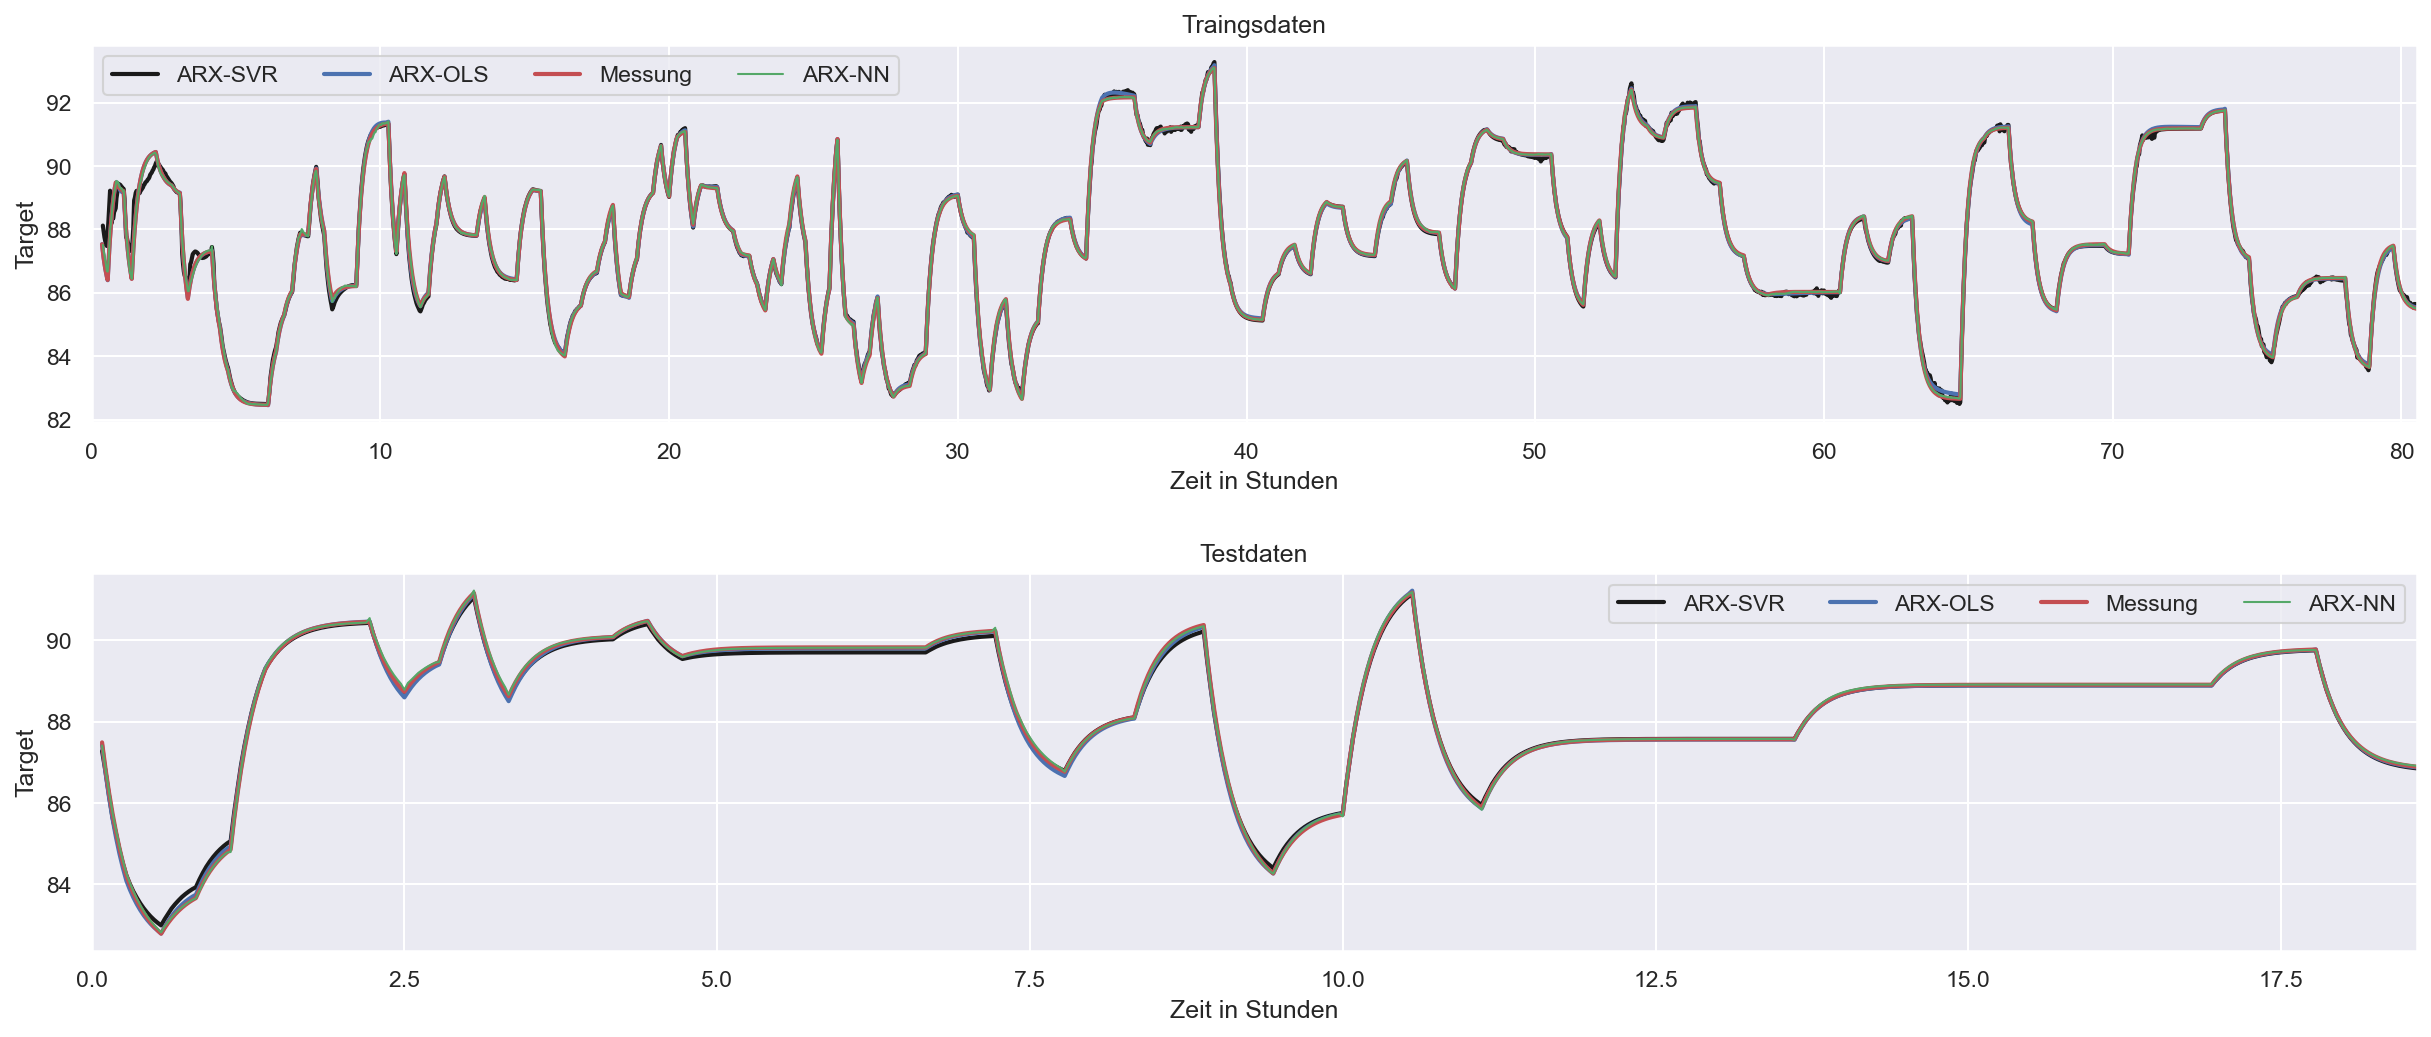

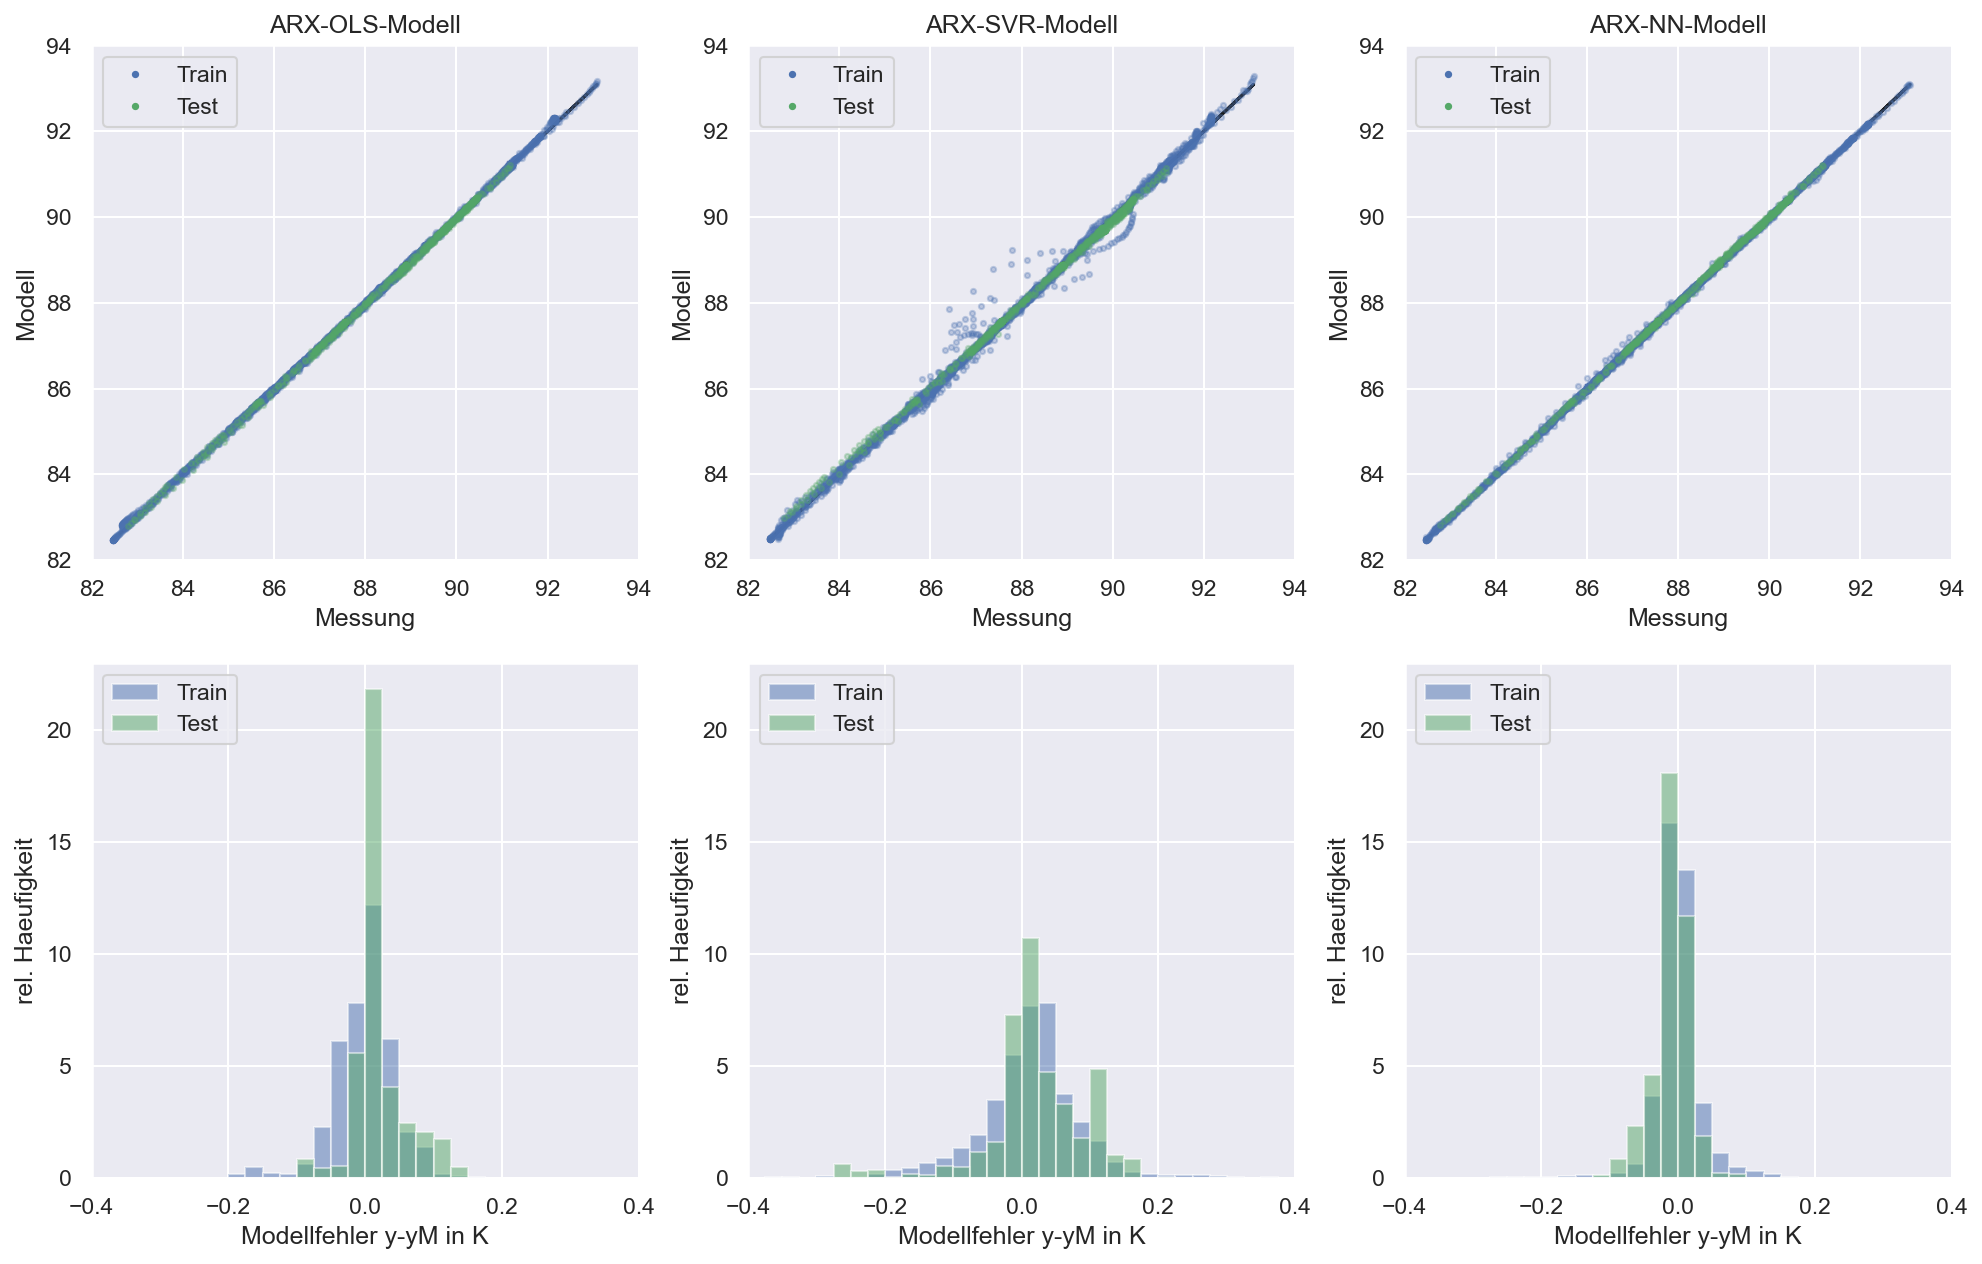

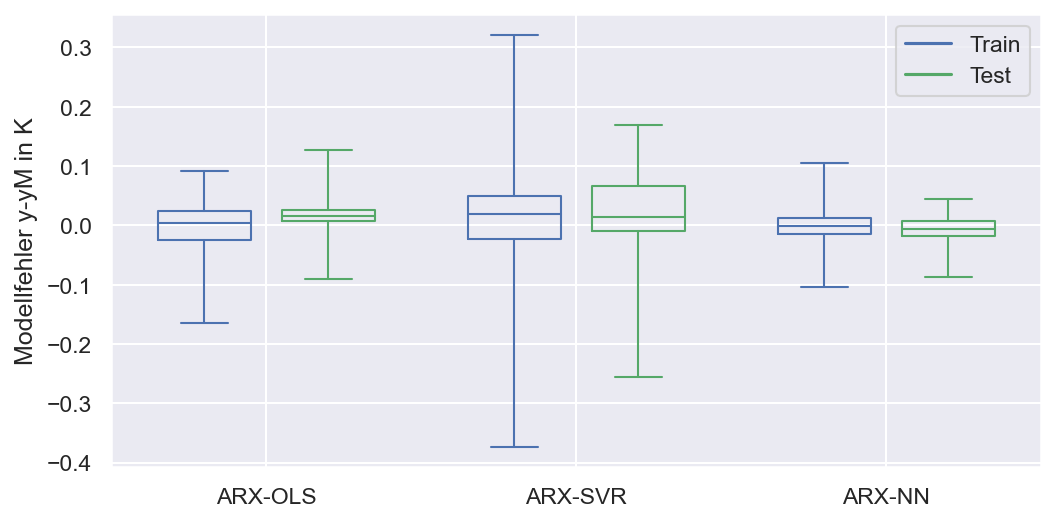

In [70]:
y_arxOLS_train  = scalery.inverse_transform(data_pOLS_opt['y']['train'].reshape(-1,1))
y_arxOLS_test   = scalery.inverse_transform(data_pOLS_opt['y']['test'].reshape(-1,1))
yM_arxOLS_train = scalery.inverse_transform(data_pOLS_opt['yM']['train'].reshape(-1,1))
yM_arxOLS_test  = scalery.inverse_transform(data_pOLS_opt['yM']['test'].reshape(-1,1))

y_arxSVR_train  = scalery.inverse_transform(data_pSVR_opt['y']['train'].reshape(-1,1))
y_arxSVR_test   = scalery.inverse_transform(data_pSVR_opt['y']['test'].reshape(-1,1))
yM_arxSVR_train = scalery.inverse_transform(data_pSVR_opt['yM']['train'].reshape(-1,1))
yM_arxSVR_test  = scalery.inverse_transform(data_pSVR_opt['yM']['test'].reshape(-1,1))

y_arxNN_train   = scalery.inverse_transform(data_pNN_opt['y']['train'].reshape(-1,1))
y_arxNN_test    = scalery.inverse_transform(data_pNN_opt['y']['test'].reshape(-1,1))
yM_arxNN_train  = scalery.inverse_transform(data_pNN_opt['yM']['train'].reshape(-1,1))
yM_arxNN_test   = scalery.inverse_transform(data_pNN_opt['yM']['test'].reshape(-1,1))


# prozentuale Fehler

e_arxOLS_train  = (y_arxOLS_train - yM_arxOLS_train)
e_arxOLS_test   = (y_arxOLS_test - yM_arxOLS_test)
PE_arxOLS_train = e_arxOLS_train/y_arxOLS_train*100
PE_arxOLS_test  = e_arxOLS_test/y_arxOLS_test*100

e_arxSVR_train  = (y_arxSVR_train - yM_arxSVR_train)
e_arxSVR_test   = (y_arxSVR_test - yM_arxSVR_test)
PE_arxSVR_train = e_arxSVR_train/y_arxSVR_train*100
PE_arxSVR_test  = e_arxSVR_test/y_arxSVR_test*100

e_arxNN_train   = (y_arxNN_train - yM_arxNN_train)
e_arxNN_test    = (y_arxNN_test - yM_arxNN_test)
PE_arxNN_train  = e_arxNN_train/y_arxNN_train*100
PE_arxNN_test   = e_arxNN_test/y_arxNN_test*100


# Plots ueber Zeit
fig1, ax = plt.subplots(2, 1, figsize=(20,8), dpi = 150)
fig1.subplots_adjust(wspace=0.2, hspace=0.4)


ax[0].plot(data_pSVR_opt['t']['train']/3600, yM_arxSVR_train,"k-", linewidth=2, label='ARX-SVR');
ax[0].plot(data_pOLS_opt['t']['train']/3600, yM_arxOLS_train,"b-", linewidth=2, label='ARX-OLS');
ax[0].plot(data_pOLS_opt['t']['train']/3600, y_arxOLS_train ,"r-", linewidth=2, label='Messung');
ax[0].plot(data_pNN_opt['t']['train']/3600 , yM_arxNN_train ,"g-", linewidth=1, label='ARX-NN');
ax[0].set_xlabel('Zeit in Stunden')
ax[0].set_ylabel('Target')
ax[0].grid('on')
ax[0].set_xlim([0, np.max(data_pOLS_opt['t']['train']/3600)])
ax[0].legend(loc='upper left', ncol = 4)
ax[0].set_title('Traingsdaten');

ax[1].plot(data_pSVR_opt['t']['test']/3600, yM_arxSVR_test,"k-", linewidth=2, label='ARX-SVR');
ax[1].plot(data_pOLS_opt['t']['test']/3600, yM_arxOLS_test,"b-", linewidth=2, label='ARX-OLS');
ax[1].plot(data_pOLS_opt['t']['test']/3600, y_arxOLS_test ,"r-", linewidth=2, label='Messung');
ax[1].plot(data_pNN_opt['t']['test']/3600 , yM_arxNN_test ,"g-", linewidth=1, label='ARX-NN');
ax[1].set_xlabel('Zeit in Stunden')
ax[1].set_ylabel('Target')
ax[1].grid('on')
ax[1].set_xlim([0, np.max(data_pOLS_opt['t']['test']/3600)])
ax[1].legend(loc='upper right', ncol = 4)
ax[1].set_title('Testdaten');



fig1, ax = plt.subplots(2, 3, figsize=(16,10), dpi = 150)
fig1.subplots_adjust(wspace=0.2, hspace=0.20)

# y-yM-Plott
ax[0,0].plot(y_arxOLS_train, y_arxOLS_train,"k-");
ax[0,0].plot(np.nan, np.nan,"b.", markersize=5, alpha = 1, label='Train');
ax[0,0].plot(np.nan, np.nan,"g.", markersize=5, alpha = 1, label='Test');
ax[0,0].plot(y_arxOLS_train, yM_arxOLS_train,"b.", markersize=5, alpha = 0.3);
ax[0,0].plot(y_arxOLS_test , yM_arxOLS_test ,"g.", markersize=5, alpha = 0.3);
ax[0,0].set_xlabel('Messung')
ax[0,0].set_ylabel('Modell')
ax[0,0].legend(loc='upper left')
ax[0,0].set_title('ARX-OLS-Modell');
ax[0,0].set_xlim([82, 94])
ax[0,0].set_ylim([82, 94])

ax[0,1].plot(y_arxSVR_train, y_arxSVR_train,"k-");
ax[0,1].plot(np.nan, np.nan,"b.", markersize=5, alpha = 1, label='Train');
ax[0,1].plot(np.nan, np.nan,"g.", markersize=5, alpha = 1, label='Test');
ax[0,1].plot(y_arxSVR_train, yM_arxSVR_train,"b.", markersize=5, alpha = 0.3);
ax[0,1].plot(y_arxSVR_test , yM_arxSVR_test ,"g.", markersize=5, alpha = 0.3);
ax[0,1].set_xlabel('Messung')
ax[0,1].set_ylabel('Modell')
ax[0,1].legend(loc='upper left')
ax[0,1].set_title('ARX-SVR-Modell');
ax[0,1].set_xlim([82, 94])
ax[0,1].set_ylim([82, 94])

ax[0,2].plot(y_arxNN_train, y_arxNN_train,"k-");
ax[0,2].plot(np.nan, np.nan,"b.", markersize=5, alpha = 1, label='Train');
ax[0,2].plot(np.nan, np.nan,"g.", markersize=5, alpha = 1, label='Test');
ax[0,2].plot(y_arxNN_train, yM_arxNN_train,"b.", markersize=5, alpha = 0.3);
ax[0,2].plot(y_arxNN_test , yM_arxNN_test ,"g.", markersize=5, alpha = 0.3);
ax[0,2].set_xlabel('Messung')
ax[0,2].set_ylabel('Modell')
ax[0,2].legend(loc='upper left')
ax[0,2].set_title('ARX-NN-Modell');
ax[0,2].set_xlim([82, 94])
ax[0,2].set_ylim([82, 94])


# Histogramme
rstep = 0.025
xmax  = 0.4
ymax  = 23

ax[1,0].hist(e_arxOLS_train, color='b', alpha = 0.5, density = True, bins=np.arange(-xmax,xmax,rstep), label='Train');
ax[1,0].hist(e_arxOLS_test , color='g', alpha = 0.5, density = True, bins=np.arange(-xmax,xmax,rstep), label='Test');
ax[1,0].legend(loc='upper left')
ax[1,0].set_xlabel('Modellfehler y-yM in K')
ax[1,0].set_ylabel('rel. Haeufigkeit');
# ax[1,0].set_title('ARX-OLS-Modell');
ax[1,0].set_xlim([-xmax,xmax]);
ax[1,0].set_ylim([0,ymax]);

ax[1,1].hist(e_arxSVR_train, color='b', alpha = 0.5, density = True, bins=np.arange(-xmax,xmax,rstep), label='Train');
ax[1,1].hist(e_arxSVR_test , color='g', alpha = 0.5, density = True, bins=np.arange(-xmax,xmax,rstep), label='Test');
ax[1,1].legend(loc='upper left')
ax[1,1].set_xlabel('Modellfehler y-yM in K')
ax[1,1].set_ylabel('rel. Haeufigkeit');
# ax[1,1].set_title('ARX-SVR-Modell');
ax[1,1].set_xlim([-xmax,xmax]);
ax[1,1].set_ylim([0,ymax]);

ax[1,2].hist(e_arxNN_train, color='b', alpha = 0.5, density = True, bins=np.arange(-xmax,xmax,rstep), label='Train');
ax[1,2].hist(e_arxNN_test , color='g', alpha = 0.5, density = True, bins=np.arange(-xmax,xmax,rstep), label='Test');
ax[1,2].legend(loc='upper left')
ax[1,2].set_xlabel('Modellfehler y-yM in K')
ax[1,2].set_ylabel('rel. Haeufigkeit');
# ax[1,1].set_title('ARX-SVR-Modell');
ax[1,2].set_xlim([-xmax,xmax]);
ax[1,2].set_ylim([0,ymax]);


# Boxplot
data_train = np.array([e_arxOLS_train, e_arxSVR_train, e_arxNN_train, np.nan])  # nan -> Workaround zum Erzeugen eines nested Arrays ...
data_test  = np.array([e_arxOLS_test , e_arxSVR_test , e_arxNN_test, np.nan])   

ticks = ['ARX-OLS', 'ARX-SVR', 'ARX-NN']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure(figsize=(8,4), dpi=150)

bpl = plt.boxplot(data_train, positions=np.arange(len(data_train))*2.0-0.4, sym='', widths=0.6, whis=[1, 99])
bpr = plt.boxplot(data_test , positions=np.arange(len(data_test)) *2.0+0.4, sym='', widths=0.6, whis=[1, 99])
set_box_color(bpl, 'b')
set_box_color(bpr, 'g')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='b', label='Train')
plt.plot([], c='g', label='Test')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-1, len(ticks)*2-1)
plt.ylabel('Modellfehler y-yM in K');


In [80]:
# Uebersichtstabelle
print('\n\n            x1 | x2 |  y | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar')
fcnl_print('ARX-OLS', x1_opt_pOLS, x2_opt_pOLS, y1_opt_pOLS, data_pOLS_opt, '')
fcnl_print('ARX-SVR', x1_opt_pSVR, x2_opt_pSVR, y1_opt_pSVR, data_pSVR_opt, 'Kernel: %s, C: %0.4e, epsilon: %0.4e' % (modell_pSVR_opt.kernel, modell_pSVR_opt.C, modell_pSVR_opt.epsilon))
fcnl_print('ARX-NN' , x1_opt_pNN,  x2_opt_pNN , y1_opt_pNN , data_pNN_opt , 'Solver: %s, Hiddenlayer: (%d,), alpha: %0.4e, max_fun: %d' % (modell_pNN_opt.solver, modell_pNN_opt.hidden_layer_sizes, modell_pNN_opt.alpha, modell_pNN_opt.max_fun))
print('\nx1: Stromdichte, x2: Eintrittstemp. der Zelle, y: Zelltemperatur')



            x1 | x2 |  y | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar
   ARX-OLS:  2 |  3 |  2 |     1.000 |     0.999 |       0.018 |       0.018 |        0.982 |        0.975 | 
   ARX-SVR:  3 |  3 |  3 |     0.997 |     0.998 |       0.052 |       0.033 |        0.948 |        0.955 | Kernel: linear, C: 1.6681e-02, epsilon: 1.0000e-02
    ARX-NN:  3 |  3 |  3 |     1.000 |     1.000 |       0.014 |       0.011 |        0.986 |        0.984 | Solver: lbfgs, Hiddenlayer: (14,), alpha: 1.0000e-01, max_fun: 350

x1: Stromdichte, x2: Eintrittstemp. der Zelle, y: Zelltemperatur


Alle drei getesten Modelle zeigen insgesamt ein gutes Ergebnis, dabei weist das ARX-NN-Modell den geringsten Fehler auf. Wenn das erste und letzte Percentil außer acht gelassen wird, liegt der maximale Fehler bei $\pm$ 0.1 K und der mittlere Fehler bei 0.01 K.  
Das ARX-OLS-Modell liefert jedoch bei einer deutlich einfacher Modellstruktur ebenfalls ein sehr gutes Ergebnis (max. Fehler: 0.17 K, mittlerer Fehler: 0.02 K).  
Es offenbart jedoch eine mögliche schwäche, wenn sowohl die Stromdichte, als auch die Eintrittstemperatur gleichzeitig einen größeren Sprung vollziehen (siehe Trainingsdatne nach 35 h und 64 h).  
Ansonsten zeigt das OLS-Modell eine bessere übereinstimmung in der Dynamik, als das Neuronale Netz. Das neuronale Netz weist insgesamt in allen Situationen einen geringen Fehle rauf, jedoch past teilweise die Dynamik nicht und vor einem Sprung in den Featurs wird häufig ein kurzer Peak erzeugt.

Der maximale und mittlere Fehler des ARX-SVR-Modell liegen mit über $\pm$ 0.3 K bzw. 0.05 K deutlich über denen der anderen Modelle. Zusätzlich zeigt das Modell mit den Trainingsdaten immer wieder eine stärker abweichende Dynamik.

Aufgrund einfacheren Modellstruktur, der guten Vorhersagequalität und der robusteren Vorhersage wird das ARX-OLS-Modell empfohlen.